In [ ]:
image_dir = r"c:\Users\ASUS\Desktop\PROJECT\CV\data\frames"

# CELL 2: Install Required Packages

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import open3d as o3d
from scipy.optimize import least_squares
from scipy.spatial import cKDTree
import plotly.graph_objects as go
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
import warnings
warnings.filterwarnings('ignore')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# DATA STRUCTURES

In [3]:
# ============================================================================
# DATA STRUCTURES
# ============================================================================

@dataclass
class CameraPose:
    """Camera pose representation"""
    R: np.ndarray  # 3x3 rotation matrix
    t: np.ndarray  # 3x1 translation vector
    image_idx: int

    def to_projection_matrix(self, K: np.ndarray) -> np.ndarray:
        """Convert to projection matrix P = K[R|t]"""
        return K @ np.hstack((self.R, self.t))

    def to_params(self) -> np.ndarray:
        """Convert to parameter vector [rvec, tvec]"""
        rvec, _ = cv2.Rodrigues(self.R)
        return np.concatenate([rvec.ravel(), self.t.ravel()])

    @staticmethod
    def from_params(params: np.ndarray, image_idx: int):
        """Create from parameter vector"""
        rvec = params[:3].reshape(3, 1)
        tvec = params[3:6].reshape(3, 1)
        R, _ = cv2.Rodrigues(rvec)
        return CameraPose(R, tvec, image_idx)


@dataclass
class Observation:
    """2D-3D correspondence"""
    image_idx: int
    point_3d_idx: int
    kp_idx: int           # keypoint index within the image
    point_2d: np.ndarray  # 2D pixel coordinates


@dataclass
class ReconstructionState:
    """Complete reconstruction state"""
    points_3d: np.ndarray
    camera_poses: Dict[int, CameraPose]
    observations: List[Observation]
    registered: Set[int]



# STEP 1: DATA LOADING & PREPROCESSING

In [4]:
# ============================================================================
# STEP 1: DATA LOADING & PREPROCESSING
# ============================================================================

class ImageLoader:
    """Handle image loading and preprocessing"""

    def __init__(self, image_folder: str, max_dim: int = 2000):
        self.image_folder = image_folder
        self.max_dim = max_dim

    def load_and_resize(self) -> Tuple[List[np.ndarray], List[str]]:
        """Load and resize all images"""
        image_paths = sorted(glob(os.path.join(self.image_folder, "*.jpg")) +
                           glob(os.path.join(self.image_folder, "*.png")))

        if not image_paths:
            raise ValueError(f"No images found in {self.image_folder}")

        images = []
        for path in tqdm(image_paths, desc="Loading images"):
            img = cv2.imread(path)
            if img is None:
                continue

            # Resize while maintaining aspect ratio
            h, w = img.shape[:2]
            scale = min(1.0, self.max_dim / max(h, w))
            new_w, new_h = int(w * scale), int(h * scale)
            img_resized = cv2.resize(img, (new_w, new_h))
            images.append(img_resized)

        print(f"✓ Loaded {len(images)} images, size: {images[0].shape}")
        return images, image_paths


# STEP 2: CAMERA CALIBRATION

In [5]:
# ============================================================================
# STEP 2: CAMERA CALIBRATION
# ============================================================================

class CameraCalibrator:
    """Extract camera intrinsics from EXIF or use defaults"""

    @staticmethod
    def get_intrinsics(image_path: str, image_shape: Tuple[int, int],
                       sensor_width_mm: float = 9.8,
                       sensor_height_mm: float = None,
                       default_fl_mm: float = 6.9) -> np.ndarray:
        """
        Compute camera intrinsic matrix K

        Args:
            image_path: Path to image file
            image_shape: (height, width) of image
            sensor_width_mm: Camera sensor width
            default_fl_mm: Default focal length if EXIF missing

        Returns:
            3x3 intrinsic matrix K
        """
        import piexif

        h, w = image_shape

        if sensor_height_mm is None:
            sensor_height_mm = sensor_width_mm

        # Try to read focal length from EXIF
        try:
            exif = piexif.load(image_path)
            fl = exif['Exif'][piexif.ExifIFD.FocalLength]
            fl_mm = fl[0] / fl[1]
            print(f"✓ EXIF focal length: {fl_mm:.2f} mm")
        except:
            fl_mm = default_fl_mm
            print(f"! Using default focal length: {fl_mm:.2f} mm")

        # Convert to pixels (use matching sensor dimension per axis)
        fx = (fl_mm / sensor_width_mm) * w
        fy = (fl_mm / sensor_height_mm) * h
        cx, cy = w / 2, h / 2

        K = np.array([
            [fx,  0, cx],
            [ 0, fy, cy],
            [ 0,  0,  1]
        ], dtype=np.float64)

        return K


# STEP 3: FEATURE EXTRACTION & MATCHING

In [6]:
# ============================================================================
# STEP 3: FEATURE EXTRACTION & MATCHING
# ============================================================================

class FeatureExtractor:
    """SIFT feature extraction"""

    def __init__(self, n_features: int = 2000):
        self.sift = cv2.SIFT_create(nfeatures=n_features)

    def extract_all(self, images: List[np.ndarray]) -> Tuple[List, List]:
        """Extract SIFT features for all images"""
        keypoints_list = []
        descriptors_list = []

        for img in tqdm(images, desc="Extracting SIFT"):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, des = self.sift.detectAndCompute(gray, None)
            keypoints_list.append(kp)
            descriptors_list.append(des)

        print(f"✓ Extracted features for {len(images)} images")
        return keypoints_list, descriptors_list


class FeatureMatcher:
    """FLANN-based feature matching"""

    def __init__(self):
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

    def match_pair(self, des1: np.ndarray, des2: np.ndarray,
                   ratio_thresh: float = 0.75) -> List:
        """Match features between two images using ratio test"""
        if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
            return []

        matches = self.matcher.knnMatch(des1, des2, k=2)

        # Lowe's ratio test
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < ratio_thresh * n.distance:
                    good_matches.append(m)

        return good_matches


# STEP 4: INITIAL TWO-VIEW RECONSTRUCTION

In [7]:
# ============================================================================
# STEP 4: INITIAL TWO-VIEW RECONSTRUCTION
# ============================================================================

class TwoViewReconstructor:
    """Initialize reconstruction from two views"""

    def __init__(self, K: np.ndarray):
        self.K = K

    def find_initial_pair(self, keypoints_list: List, descriptors_list: List,
                          matcher: FeatureMatcher,
                          min_matches: int = 100) -> Tuple[int, int, List]:
        """Find the best initial image pair"""
        print("Finding initial pair...")

        best_pair = None
        best_matches = []
        best_score = 0

        # Search first 20 image pairs for good baseline
        for i in range(min(20, len(keypoints_list) - 1)):
            for j in range(i + 1, min(i + 5, len(keypoints_list))):
                matches = matcher.match_pair(descriptors_list[i], descriptors_list[j])

                if len(matches) > min_matches:
                    # Score based on number of matches and baseline
                    score = len(matches) * (j - i)  # favor wider baseline
                    if score > best_score:
                        best_score = score
                        best_pair = (i, j)
                        best_matches = matches

        if best_pair is None:
            raise ValueError("Could not find suitable initial pair")

        print(f"✓ Initial pair: images {best_pair[0]} and {best_pair[1]} "
              f"with {len(best_matches)} matches")
        return best_pair[0], best_pair[1], best_matches

    def reconstruct(self, keypoints_list: List, matches: List,
                   i0: int, i1: int) -> Tuple[CameraPose, CameraPose,
                                               np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Compute initial camera poses and 3D points
        Returns points_3d, kept_match_indices, filtered 2D points"""
        # Extract matched point coordinates
        pts1 = np.float32([keypoints_list[i0][m.queryIdx].pt for m in matches])
        pts2 = np.float32([keypoints_list[i1][m.trainIdx].pt for m in matches])

        # Estimate essential matrix
        E, mask = cv2.findEssentialMat(pts1, pts2, self.K,
                                       method=cv2.RANSAC,
                                       prob=0.999,
                                       threshold=1.0)

        # Recover pose
        _, R, t, pose_mask = cv2.recoverPose(E, pts1, pts2, self.K, mask=mask)

        # Filter inliers
        inliers = pose_mask.ravel().astype(bool)
        match_indices = np.where(inliers)[0]
        pts1_inl = pts1[inliers]
        pts2_inl = pts2[inliers]

        # Triangulate points
        P1 = self.K @ np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = self.K @ np.hstack((R, t))

        points_4d = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)
        points_3d = (points_4d[:3] / points_4d[3]).T

        # Filter points behind camera
        valid = (points_3d[:, 2] > 0)
        points_3d = points_3d[valid]
        pts1_inl = pts1_inl[valid]
        pts2_inl = pts2_inl[valid]
        match_indices = match_indices[valid]

        # Create camera poses
        pose0 = CameraPose(np.eye(3), np.zeros((3, 1)), i0)
        pose1 = CameraPose(R, t, i1)

        print(f"✓ Initial reconstruction: {len(points_3d)} 3D points")
        return pose0, pose1, points_3d, match_indices, pts1_inl, pts2_inl



# STEP 5: INCREMENTAL RECONSTRUCTION WITH PnP

In [8]:
# ============================================================================
# STEP 5: INCREMENTAL RECONSTRUCTION WITH PnP
# ============================================================================

class IncrementalReconstructor:
    """Incrementally add images using PnP"""

    def __init__(self, K: np.ndarray, min_2d3d_matches: int = 10):
        self.K = K
        self.min_2d3d_matches = min_2d3d_matches

    def find_2d3d_correspondences(self, new_idx: int,
                                 registered_indices: Set[int],
                                 keypoints_list: List,
                                 matcher: FeatureMatcher,
                                 descriptors_list: List,
                                 observations: List[Observation],
                                 points_3d: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Find 2D-3D correspondences for a new image"""
        pts3d = []
        pts2d = []
        point_indices = []

        # Build lookup (image_idx, kp_idx) -> point3d_idx
        obs_map = { (obs.image_idx, obs.kp_idx): obs.point_3d_idx for obs in observations }

        # Match with multiple registered images
        for reg_idx in registered_indices:
            matches = matcher.match_pair(descriptors_list[reg_idx],
                                        descriptors_list[new_idx])

            for m in matches:
                key = (reg_idx, m.queryIdx)
                if key in obs_map and obs_map[key] < len(points_3d):
                    pts3d.append(points_3d[obs_map[key]])
                    pts2d.append(keypoints_list[new_idx][m.trainIdx].pt)
                    point_indices.append(obs_map[key])

        if len(pts3d) < self.min_2d3d_matches:
            return np.array([]), np.array([]), np.array([])

        return np.array(pts3d), np.array(pts2d), np.array(point_indices)

    def register_image(self, image_idx: int, pts3d: np.ndarray,
                      pts2d: np.ndarray) -> Tuple[bool, CameraPose]:
        """Register a new image using PnP RANSAC"""
        if len(pts3d) < self.min_2d3d_matches:
            return False, None

        # PnP with RANSAC for robustness
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            pts3d, pts2d, self.K, None,
            reprojectionError=4.0,
            confidence=0.999,
            iterationsCount=1000,
            flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not success or inliers is None or len(inliers) < self.min_2d3d_matches:
            return False, None

        R, _ = cv2.Rodrigues(rvec)
        t = tvec.reshape((3, 1))

        pose = CameraPose(R, t, image_idx)

        return True, pose

# STEP 6: TRIANGULATION WITH QUALITY CHECKS

In [9]:
# ============================================================================
# STEP 6: TRIANGULATION WITH QUALITY CHECKS
# ============================================================================

class Triangulator:
    """Triangulate 3D points with quality filtering"""

    @staticmethod
    def triangulate_points(pose1: CameraPose, pose2: CameraPose,
                          pts1: np.ndarray, pts2: np.ndarray,
                          K: np.ndarray) -> np.ndarray:
        """Triangulate points between two views"""
        P1 = pose1.to_projection_matrix(K)
        P2 = pose2.to_projection_matrix(K)

        points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
        points_3d = (points_4d[:3] / points_4d[3]).T

        return points_3d

    @staticmethod
    def filter_triangulated_points(points_3d: np.ndarray,
                                   pose1: CameraPose, pose2: CameraPose,
                                   pts1: np.ndarray, pts2: np.ndarray,
                                   K: np.ndarray,
                                   max_reproj_error: float = 2.0,
                                   min_depth: float = 0.1,
                                   max_depth: float = 500.0) -> np.ndarray:
        """Filter triangulated points based on quality criteria"""
        valid_mask = np.ones(len(points_3d), dtype=bool)

        # Filter by depth
        depths1 = pose1.R @ points_3d.T + pose1.t
        depths2 = pose2.R @ points_3d.T + pose2.t
        valid_mask &= (depths1[2] > min_depth) & (depths1[2] < max_depth)
        valid_mask &= (depths2[2] > min_depth) & (depths2[2] < max_depth)

        # Filter by reprojection error
        P1 = pose1.to_projection_matrix(K)
        P2 = pose2.to_projection_matrix(K)

        pts1_proj = (P1 @ np.hstack([points_3d, np.ones((len(points_3d), 1))]).T)
        pts1_proj = (pts1_proj[:2] / pts1_proj[2]).T

        pts2_proj = (P2 @ np.hstack([points_3d, np.ones((len(points_3d), 1))]).T)
        pts2_proj = (pts2_proj[:2] / pts2_proj[2]).T

        error1 = np.linalg.norm(pts1 - pts1_proj, axis=1)
        error2 = np.linalg.norm(pts2 - pts2_proj, axis=1)

        valid_mask &= (error1 < max_reproj_error) & (error2 < max_reproj_error)

        return valid_mask


# STEP 7: BUNDLE ADJUSTMENT (REFINEMENT)

In [10]:
# ============================================================================
# STEP 7: BUNDLE ADJUSTMENT (REFINEMENT)
# ============================================================================

class BundleAdjuster:
    """Optimize camera poses and 3D points jointly"""

    def __init__(self, K: np.ndarray):
        self.K = K

    def prepare_parameters(self, camera_poses: Dict[int, CameraPose],
                          points_3d: np.ndarray) -> np.ndarray:
        """Pack camera poses and points into parameter vector"""
        n_cameras = len(camera_poses)
        n_points = len(points_3d)

        params = np.zeros(n_cameras * 6 + n_points * 3)

        # Pack camera parameters
        for i, (img_idx, pose) in enumerate(sorted(camera_poses.items())):
            params[i * 6:(i + 1) * 6] = pose.to_params()

        # Pack point parameters
        params[n_cameras * 6:] = points_3d.ravel()

        return params

    def unpack_parameters(self, params: np.ndarray,
                         camera_indices: List[int],
                         n_points: int) -> Tuple[Dict[int, CameraPose], np.ndarray]:
        """Unpack parameter vector into poses and points"""
        n_cameras = len(camera_indices)

        camera_poses = {}
        for i, img_idx in enumerate(camera_indices):
            camera_params = params[i * 6:(i + 1) * 6]
            camera_poses[img_idx] = CameraPose.from_params(camera_params, img_idx)

        points_3d = params[n_cameras * 6:].reshape((n_points, 3))

        return camera_poses, points_3d

    def compute_residuals(self, params: np.ndarray,
                         observations: List[Observation],
                         camera_indices: List[int],
                         n_points: int) -> np.ndarray:
        """Compute reprojection residuals"""
        camera_poses, points_3d = self.unpack_parameters(params, camera_indices, n_points)

        residuals = []

        for obs in observations:
            if obs.image_idx not in camera_poses:
                continue
            if obs.point_3d_idx >= len(points_3d):
                continue

            pose = camera_poses[obs.image_idx]
            point_3d = points_3d[obs.point_3d_idx]

            # Project 3D point to 2D
            point_cam = pose.R @ point_3d + pose.t.ravel()
            point_2d_proj = self.K @ point_cam
            point_2d_proj = point_2d_proj[:2] / point_2d_proj[2]

            # Compute residual
            residual = obs.point_2d - point_2d_proj
            residuals.extend(residual)

        return np.array(residuals)

    def optimize(self, camera_poses: Dict[int, CameraPose],
                points_3d: np.ndarray,
                observations: List[Observation],
                max_iterations: int = 50) -> Tuple[Dict[int, CameraPose], np.ndarray]:
        """Run bundle adjustment optimization"""
        print("\n" + "="*70)
        print("BUNDLE ADJUSTMENT OPTIMIZATION")
        print("="*70)

        camera_indices = sorted(camera_poses.keys())
        n_cameras = len(camera_indices)
        n_points = len(points_3d)
        n_observations = len(observations)

        print(f"Cameras: {n_cameras}")
        print(f"Points: {n_points}")
        print(f"Observations: {n_observations}")

        # Prepare initial parameters
        params_init = self.prepare_parameters(camera_poses, points_3d)

        # Compute initial error
        residuals_init = self.compute_residuals(params_init, observations,
                                               camera_indices, n_points)
        error_init = np.sqrt(np.mean(residuals_init**2))
        print(f"\nInitial RMSE: {error_init:.3f} pixels")

        # Run optimization
        print("\nOptimizing...")
        result = least_squares(
            self.compute_residuals,
            params_init,
            args=(observations, camera_indices, n_points),
            method='trf',
            max_nfev=max_iterations,
            verbose=2,
            ftol=1e-4,
            xtol=1e-4
        )

        # Unpack optimized parameters
        camera_poses_opt, points_3d_opt = self.unpack_parameters(
            result.x, camera_indices, n_points
        )

        # Compute final error
        residuals_final = self.compute_residuals(result.x, observations,
                                                camera_indices, n_points)
        error_final = np.sqrt(np.mean(residuals_final**2))

        print(f"\n{'='*70}")
        print(f"OPTIMIZATION COMPLETE")
        print(f"{'='*70}")
        print(f"Initial RMSE: {error_init:.3f} pixels")
        print(f"Final RMSE: {error_final:.3f} pixels")
        print(f"Improvement: {error_init - error_final:.3f} pixels "
              f"({(1 - error_final/error_init)*100:.1f}%)")
        print(f"{'='*70}\n")

        return camera_poses_opt, points_3d_opt


# STEP 8: OUTLIER REMOVAL & POINT CLOUD CLEANING

In [11]:
# ============================================================================
# STEP 8: OUTLIER REMOVAL & POINT CLOUD CLEANING
# ============================================================================

class PointCloudCleaner:
    """Clean and filter point cloud"""

    @staticmethod
    def remove_statistical_outliers(points: np.ndarray,
                                    nb_neighbors: int = 20,
                                    std_ratio: float = 2.0) -> np.ndarray:
        """Remove statistical outliers using Open3D"""
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        pcd_clean, ind = pcd.remove_statistical_outlier(
            nb_neighbors=nb_neighbors,
            std_ratio=std_ratio
        )

        points_clean = np.asarray(pcd_clean.points)
        print(f"✓ Statistical outlier removal: {len(points)} → {len(points_clean)} points")

        return points_clean

    @staticmethod
    def remove_extreme_points(points: np.ndarray,
                            threshold: float = 1000.0) -> np.ndarray:
        """Remove points with extreme coordinates"""
        mask = (np.abs(points) < threshold).all(axis=1)
        points_clean = points[mask]

        print(f"✓ Extreme point removal: {len(points)} → {len(points_clean)} points")
        return points_clean

    @staticmethod
    def remove_duplicate_points(points: np.ndarray,
                               tolerance: float = 0.01) -> np.ndarray:
        """Remove duplicate points"""
        if len(points) == 0:
            return points

        tree = cKDTree(points)
        pairs = tree.query_pairs(r=tolerance)

        remove_indices = set()
        for i, j in pairs:
            remove_indices.add(j)

        keep_indices = [i for i in range(len(points)) if i not in remove_indices]
        points_clean = points[keep_indices]

        print(f"✓ Duplicate removal: {len(points)} → {len(points_clean)} points")
        return points_clean



# STEP 9: VISUALIZATION

In [12]:
# ============================================================================
# STEP 9: VISUALIZATION
# ============================================================================

class Visualizer:
    """Visualization utilities"""

    @staticmethod
    def plot_point_cloud_plotly(points: np.ndarray, title: str = "Point Cloud"):
        """Interactive 3D visualization with Plotly"""
        fig = go.Figure(data=[go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=points[:, 2],
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(title="Z Depth")
            )
        )])

        fig.update_layout(
            title=title,
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='data'
            ),
            width=1000,
            height=700,
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig.show()

    @staticmethod
    def save_point_cloud(points: np.ndarray, filename: str, color=None):
        """Save point cloud to PLY file"""
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        if color is not None:
            pcd.paint_uniform_color(color)
        else:
            pcd.paint_uniform_color([0.2, 0.6, 1.0])

        o3d.io.write_point_cloud(filename, pcd)
        print(f"✓ Saved point cloud: {filename}")

    @staticmethod
    def compare_point_clouds(points_before: np.ndarray,
                           points_after: np.ndarray):
        """Compare before/after point clouds"""
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        axes[0].scatter(points_before[:, 0], points_before[:, 2],
                       s=1, alpha=0.5, c=points_before[:, 2], cmap='viridis')
        axes[0].set_title(f'Before Refinement ({len(points_before)} points)')
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Z')
        axes[0].axis('equal')

        axes[1].scatter(points_after[:, 0], points_after[:, 2],
                       s=1, alpha=0.5, c=points_after[:, 2], cmap='viridis')
        axes[1].set_title(f'After Bundle Adjustment ({len(points_after)} points)')
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Z')
        axes[1].axis('equal')

        plt.tight_layout()
        plt.show()




# MAIN PIPELINE


STRUCTURE FROM MOTION PIPELINE

STEP 1: Loading Images
----------------------------------------------------------------------


Loading images: 100%|██████████| 217/217 [00:41<00:00,  5.19it/s]


✓ Loaded 217 images, size: (640, 360, 3)

STEP 2: Camera Calibration
----------------------------------------------------------------------
✓ EXIF focal length: 6.90 mm
Camera intrinsics K:
[[253.46938776   0.         180.        ]
 [  0.         450.6122449  320.        ]
 [  0.           0.           1.        ]]

STEP 3: Feature Extraction
----------------------------------------------------------------------


Extracting SIFT: 100%|██████████| 217/217 [00:08<00:00, 24.58it/s]


✓ Extracted features for 217 images

STEP 4: Feature Matching
----------------------------------------------------------------------

STEP 5: Initial Two-View Reconstruction
----------------------------------------------------------------------
Finding initial pair...
✓ Initial pair: images 16 and 18 with 187 matches
✓ Initial reconstruction: 148 3D points
Initial observations: 296

STEP 6: Incremental PnP Registration
----------------------------------------------------------------------

Iteration 1: 215 images remaining


Registering images: 100%|██████████| 215/215 [00:08<00:00, 24.66it/s]


✓ Registered 5 images. Total: 7/217
  Total 3D points: 390

Iteration 2: 210 images remaining


Registering images: 100%|██████████| 210/210 [00:33<00:00,  6.21it/s]


✓ Registered 9 images. Total: 16/217
  Total 3D points: 444

Iteration 3: 201 images remaining


Registering images: 100%|██████████| 201/201 [01:15<00:00,  2.65it/s]


✓ Registered 3 images. Total: 19/217
  Total 3D points: 455

Iteration 4: 198 images remaining


Registering images: 100%|██████████| 198/198 [01:19<00:00,  2.50it/s]


✓ Registered 1 images. Total: 20/217
  Total 3D points: 455

Iteration 5: 197 images remaining


Registering images: 100%|██████████| 197/197 [01:19<00:00,  2.49it/s]


✓ Registered 1 images. Total: 21/217
  Total 3D points: 455

Iteration 6: 196 images remaining


Registering images: 100%|██████████| 196/196 [03:10<00:00,  1.03it/s]


No more images can be registered. Stopping.

INCREMENTAL RECONSTRUCTION COMPLETE
Registered images: 21/217
Total 3D points: 455
Total observations: 910

✓ Saved point cloud: week3_sparse_before_BA.ply
STEP 7: Bundle Adjustment (Refinement)
----------------------------------------------------------------------

BUNDLE ADJUSTMENT OPTIMIZATION
Cameras: 21
Points: 455
Observations: 910

Initial RMSE: 0.398 pixels

Optimizing...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4430e+02                                    1.18e+04    
       1              5         8.2657e+01      6.16e+01       2.75e+00       2.45e+03    
       2              7         7.3092e+01      9.56e+00       1.37e+00       1.84e+03    
       3              8         6.9412e+01      3.68e+00       1.37e+00       1.68e+03    
       4              9         6.6863e+01      2.55e+00       1.37e+00       9.10e+02    
       5             11   

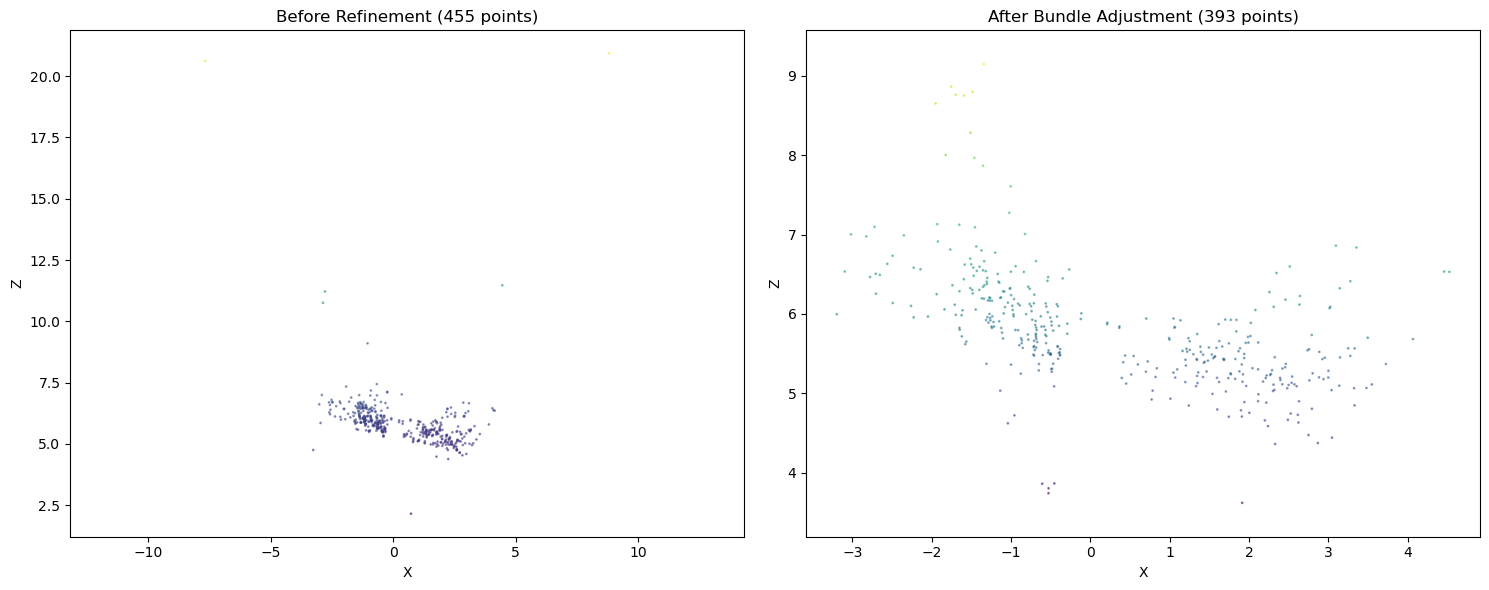


SfM PIPELINE COMPLETE 

Output files:
  - week3_sparse_before_BA.ply
  - week3_sparse_after_BA.ply
  - week3_sparse_final.ply

Reconstruction statistics:
  - Registered images: 21/217
  - Final point cloud: 393 points
  - Camera poses: 21
✓ Point cloud shape: (455, 3)
✓ Registered cameras: 21


In [13]:
# ============================================================================
# MAIN PIPELINE
# ============================================================================

class SfMPipeline:
    """Complete Structure from Motion pipeline"""

    def __init__(self, image_folder: str, max_dim: int = 640):
        self.image_folder = image_folder
        self.max_dim = max_dim
        self.state = None

    def run(self):
        """Execute complete SfM pipeline"""
        print("\n" + "="*70)
        print("STRUCTURE FROM MOTION PIPELINE")
        print("="*70 + "\n")

        # Step 1: Load images
        print("STEP 1: Loading Images")
        print("-" * 70)
        loader = ImageLoader(self.image_folder, self.max_dim)
        images, image_paths = loader.load_and_resize()

        # Step 2: Camera calibration
        print("\nSTEP 2: Camera Calibration")
        print("-" * 70)
        h, w = images[0].shape[:2]
        K = CameraCalibrator.get_intrinsics(image_paths[0], (h, w))
        print(f"Camera intrinsics K:\n{K}\n")

        # Step 3: Feature extraction
        print("STEP 3: Feature Extraction")
        print("-" * 70)
        extractor = FeatureExtractor(n_features=2000)
        keypoints_list, descriptors_list = extractor.extract_all(images)

        # Step 4: Feature matching
        print("\nSTEP 4: Feature Matching")
        print("-" * 70)
        matcher = FeatureMatcher()

        # Step 5: Initial reconstruction
        print("\nSTEP 5: Initial Two-View Reconstruction")
        print("-" * 70)
        two_view = TwoViewReconstructor(K)
        i0, i1, matches01 = two_view.find_initial_pair(
            keypoints_list, descriptors_list, matcher
        )

        pose0, pose1, points_3d_init, kept_match_indices, pts1_filt, pts2_filt = two_view.reconstruct(
            keypoints_list, matches01, i0, i1
        )

        # Initialize reconstruction state
        camera_poses = {i0: pose0, i1: pose1}
        registered = {i0, i1}
        points_3d = points_3d_init.copy()

        # Create initial observations
        observations = []
        # Build observations aligned with filtered 3D points
        for idx, match_idx in enumerate(kept_match_indices):
            if idx < len(points_3d_init):
                m = matches01[match_idx]
                observations.append(Observation(i0, idx, m.queryIdx, pts1_filt[idx]))
                observations.append(Observation(i1, idx, m.trainIdx, pts2_filt[idx]))

        print(f"Initial observations: {len(observations)}")

        # Step 6: Incremental reconstruction
        print("\nSTEP 6: Incremental PnP Registration")
        print("-" * 70)
        incremental = IncrementalReconstructor(K, min_2d3d_matches=15)
        triangulator = Triangulator()

        unregistered = [i for i in range(len(images)) if i not in registered]
        iteration = 0
        max_iterations = 10

        while len(unregistered) > 0 and iteration < max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}: {len(unregistered)} images remaining")

            newly_registered = []

            for j in tqdm(unregistered, desc="Registering images"):
                # Find 2D-3D correspondences
                pts3d, pts2d, pt_indices = incremental.find_2d3d_correspondences(
                    j, registered, keypoints_list, matcher,
                    descriptors_list, observations, points_3d
                )

                if len(pts3d) < 15:
                    continue

                # Register image with PnP
                success, pose_j = incremental.register_image(j, pts3d, pts2d)

                if success:
                    newly_registered.append((j, pose_j))

            if len(newly_registered) == 0:
                print("No more images can be registered. Stopping.")
                break

            # Add newly registered images and triangulate new points
            for j, pose_j in newly_registered:
                registered.add(j)
                camera_poses[j] = pose_j

                # Triangulate with best registered image
                best_ref = i0  # Use first image as reference
                matches_new = matcher.match_pair(
                    descriptors_list[best_ref],
                    descriptors_list[j]
                )

                if len(matches_new) < 20:
                    continue

                pts_ref = np.float32([keypoints_list[best_ref][m.queryIdx].pt
                                     for m in matches_new])
                pts_new = np.float32([keypoints_list[j][m.trainIdx].pt
                                     for m in matches_new])

                # Triangulate
                points_new = triangulator.triangulate_points(
                    camera_poses[best_ref], pose_j, pts_ref, pts_new, K
                )

                # Filter by quality
                valid_mask = triangulator.filter_triangulated_points(
                    points_new, camera_poses[best_ref], pose_j,
                    pts_ref, pts_new, K
                )

                points_new_filtered = points_new[valid_mask]
                pts_ref_filtered = pts_ref[valid_mask]
                pts_new_filtered = pts_new[valid_mask]

                keep_ids = np.nonzero(valid_mask)[0]

                # Add to reconstruction
                start_idx = len(points_3d)
                points_3d = np.vstack([points_3d, points_new_filtered])

                # Add observations with kp indices
                for local_idx, match_idx in enumerate(keep_ids):
                    point_idx = start_idx + local_idx
                    m = matches_new[match_idx]
                    observations.append(Observation(best_ref, point_idx, m.queryIdx, pts_ref_filtered[local_idx]))
                    observations.append(Observation(j, point_idx, m.trainIdx, pts_new_filtered[local_idx]))

            print(f"✓ Registered {len(newly_registered)} images. "
                  f"Total: {len(registered)}/{len(images)}")
            print(f"  Total 3D points: {len(points_3d)}")

            unregistered = [i for i in range(len(images)) if i not in registered]

        print(f"\n{'='*70}")
        print(f"INCREMENTAL RECONSTRUCTION COMPLETE")
        print(f"{'='*70}")
        print(f"Registered images: {len(registered)}/{len(images)}")
        print(f"Total 3D points: {len(points_3d)}")
        print(f"Total observations: {len(observations)}")
        print(f"{'='*70}\n")

        # Save initial reconstruction
        points_3d_before = points_3d.copy()
        Visualizer.save_point_cloud(points_3d, "week3_sparse_before_BA.ply")

        # Step 7: Bundle Adjustment
        print("STEP 7: Bundle Adjustment (Refinement)")
        print("-" * 70)
        ba = BundleAdjuster(K)
        camera_poses_refined, points_3d_refined = ba.optimize(
            camera_poses, points_3d, observations, max_iterations=50
        )

        # Step 8: Point cloud cleaning
        print("STEP 8: Point Cloud Cleaning")
        print("-" * 70)
        cleaner = PointCloudCleaner()

        points_3d_clean = cleaner.remove_extreme_points(points_3d_refined, threshold=1000)
        points_3d_clean = cleaner.remove_statistical_outliers(points_3d_clean,
                                                              nb_neighbors=20,
                                                              std_ratio=2.0)
        points_3d_clean = cleaner.remove_duplicate_points(points_3d_clean, tolerance=0.01)

        print(f"\n{'='*70}")
        print(f"FINAL POINT CLOUD")
        print(f"{'='*70}")
        print(f"Before BA: {len(points_3d_before)} points")
        print(f"After BA: {len(points_3d_refined)} points")
        print(f"After cleaning: {len(points_3d_clean)} points")
        print(f"{'='*70}\n")

        # Step 9: Save and visualize results
        print("STEP 9: Saving Results")
        print("-" * 70)
        Visualizer.save_point_cloud(points_3d_refined, "week3_sparse_after_BA.ply")
        Visualizer.save_point_cloud(points_3d_clean, "week3_sparse_final.ply")

        print("\nSTEP 10: Visualization")
        print("-" * 70)

        # Compare before/after
        if len(points_3d_before) < 100000:  # Only plot if not too many points
            Visualizer.compare_point_clouds(points_3d_before, points_3d_clean)

        # Interactive 3D plot
        if len(points_3d_clean) < 50000:
            Visualizer.plot_point_cloud_plotly(points_3d_clean,
                                              "Week 3: Final Refined Point Cloud")

        # Store final state
        self.state = ReconstructionState(
            points_3d=points_3d_refined,
            camera_poses=camera_poses_refined,
            observations=observations,
            registered=registered
        )

        print("\n" + "="*70)
        print("SfM PIPELINE COMPLETE ")
        print("="*70)
        print(f"\nOutput files:")
        print(f"  - week3_sparse_before_BA.ply")
        print(f"  - week3_sparse_after_BA.ply")
        print(f"  - week3_sparse_final.ply")
        print(f"\nReconstruction statistics:")
        print(f"  - Registered images: {len(registered)}/{len(images)}")
        print(f"  - Final point cloud: {len(points_3d_clean)} points")
        print(f"  - Camera poses: {len(camera_poses_refined)}")

        return self.state


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Configuration
    IMAGE_FOLDER = r"C:\Users\ASUS\Desktop\PROJECT\CV\images"
    MAX_DIM = 640

    # Run pipeline
    pipeline = SfMPipeline(IMAGE_FOLDER, MAX_DIM)
    state = pipeline.run()

    # Access results

    print(f"✓ Point cloud shape: {state.points_3d.shape}")
    print(f"✓ Registered cameras: {len(state.camera_poses)}")

Loading point cloud from: week3_sparse_after_BA.ply
Loaded 455 points.


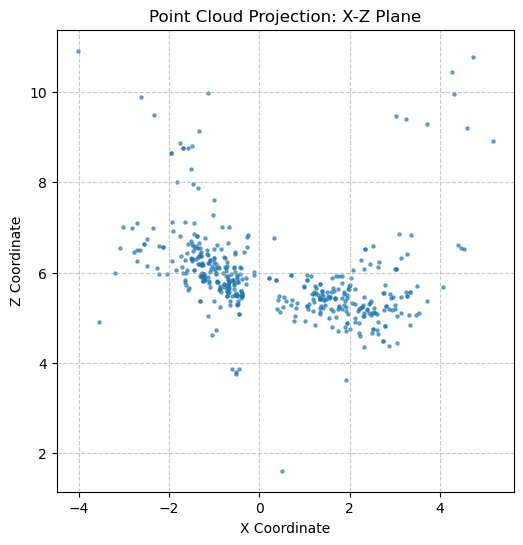

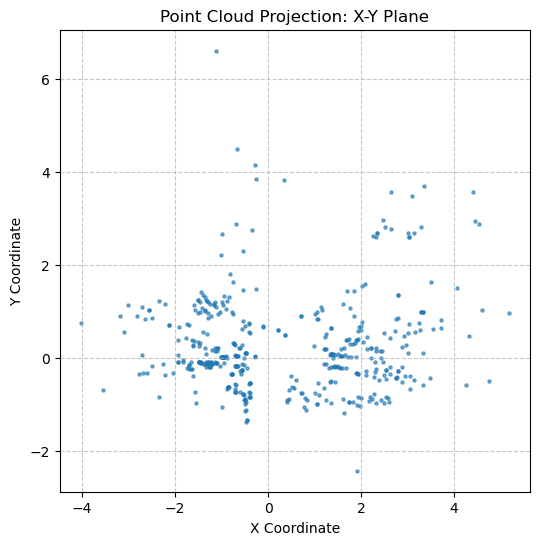

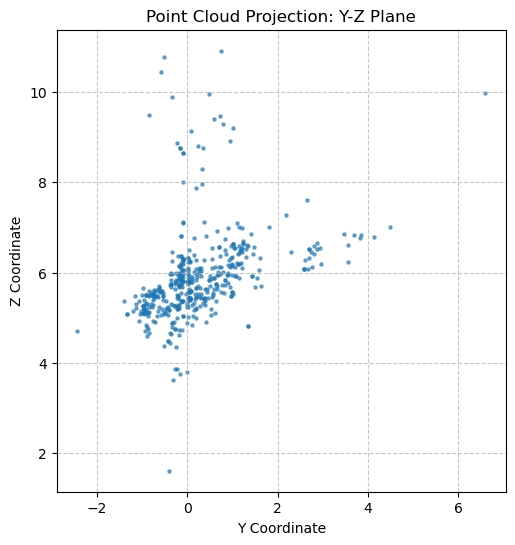

2D images of the point cloud projections created successfully.


In [17]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Path to the final point cloud file
file_path = 'week3_sparse_after_BA.ply'

print(f"Loading point cloud from: {file_path}")
pcd = o3d.io.read_point_cloud(file_path)
points = np.asarray(pcd.points)

if points.shape[0] == 0:
    print("The point cloud is empty, cannot create 2D images.")
else:
    print(f"Loaded {points.shape[0]} points.")

    # Projection 1: X-Z Plane (Top-down view if Y is up, or front view if Z is depth)
    fig_xz = plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 2], s=5, alpha=0.6)
    plt.title('Point Cloud Projection: X-Z Plane')
    plt.xlabel('X Coordinate')
    plt.ylabel('Z Coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Projection 2: X-Y Plane (Front view if Z is depth, or top-down if Z is up)
    fig_xy = plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], s=5, alpha=0.6)
    plt.title('Point Cloud Projection: X-Y Plane')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Projection 3: Y-Z Plane (Side view)
    fig_yz = plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 1], points[:, 2], s=5, alpha=0.6)
    plt.title('Point Cloud Projection: Y-Z Plane')
    plt.xlabel('Y Coordinate')
    plt.ylabel('Z Coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print("2D images of the point cloud projections created successfully.")
